
# Generation-based MRC

Google의 T5(T5: Text-To-Text Transfer Transformer)의 text-to-text 형태로 한국어 QA Task를 위한 Transformer 모델입니다

![](https://oopy.lazyrockets.com/api/v2/notion/image?src=https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fd4cee633-7697-44e7-9ee4-39e67b08e44f%2FUntitled.png&blockId=d9b35607-b251-41d8-b62d-d547936af896)

* version_1 
  * data : groom competition에서 주어진 데이터
  * model : T5
  * parameter : max_length -> 512, learning_late -> 0.0001, epoch -> 5, batch_size -> 4 


* version_2 
  * data : groom competition에서 주어진 데이터 + AI hub 
  * model : T5
  * parameter : max_length -> 512, learning_late -> 0.0001, epoch -> 5, batch_size -> 4   

In [ ]:
# tpu 연결
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 144.6 MB 44 kB/s 
     |████████████████████████████████| 57 kB 2.8 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.288 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece
!pip install bertviz
!pip install plotly



!pip install pyyaml==5.1
!pip install torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install 'git+https://github.com/facebookresearch/mobile-vision.git'


     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 68.8 MB/s 
     |████████████████████████████████| 3.3 MB 65.0 MB/s 
     |████████████████████████████████| 596 kB 78.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 329 kB 71.2 MB/s 
     |████████████████████████████████| 132 kB 76.9 MB/s 
     |████████████████████████████████| 829 kB 66.5 MB/s 
     |████████████████████████████████| 1.1 MB 73.2 MB/s 
     |████████████████████████████████| 160 kB 81.8 MB/s 
     |████████████████████████████████| 192 kB 81.3 MB/s 
     |████████████████████████████████| 271 kB 78.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=10843aa649ba9f

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path # 파일시스템의 경로를 단순한 문자열이 아닌 객체로 다루게 하는 것
from torch.utils.data import Dataset, DataLoader
import torchtext
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from termcolor import colored
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim



from transformers import (
     AdamW,
     T5ForConditionalGeneration,
     T5Tokenizer,
     get_linear_schedule_with_warmup
 )
from tqdm.auto import tqdm
from bertviz import head_view

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import gc


import warnings

warnings.filterwarnings(action='ignore') 
from plotly import graph_objs as go

from collections import Counter
import plotly.express as px


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 10, 10

In [ ]:
pl.seed_everything(42)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Global seed set to 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")

with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())



with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [ ]:
TRAIN_DATA['data'][0]['paragraphs'][0]['qas'][0]['answers']

[{'answer_start': 478, 'text': '한 달가량'}, {'answer_start': 478, 'text': '한 달'}]

In [ ]:
train = pd.DataFrame(columns=['guid' ,'title' ,'news_category', 'context', 'question' ,'answer_start', 'text'])
guid = 0
for data in TRAIN_DATA['data']:
    for paragraphs in data['paragraphs']:
        for line in paragraphs['qas']:
            train.loc[guid, 'context'] = paragraphs['context']
            train.loc[guid, 'question'] = line['question']
            train.loc[guid, 'answer_start'] = line['answers'][0]['answer_start']
            train.loc[guid, 'text'] = line['answers'][0]['text']            
            train.loc[guid, 'title'] = data['title']
            train.loc[guid, 'guid'] = line['guid']
            train.loc[guid, 'news_category'] = data['news_category']
            guid += 1
  


In [ ]:
test = pd.DataFrame(columns=['guid','title' ,'news_category', 'context', 'question' ])
guid = 0
for data in TEST_DATA['data']:
    for paragraphs in data['paragraphs']:
        for line in paragraphs['qas']:
            test.loc[guid, 'context'] = paragraphs['context']
            test.loc[guid, 'question'] = line['question']
            test.loc[guid, 'title'] = data['title']
            test.loc[guid, 'guid'] = line['guid']
            test.loc[guid, 'news_category'] = data['news_category']
            guid += 1
        

* AI Hub data 추가

In [ ]:
'''
DIR = "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/Korean MRC/data"
TRAIN_SOURCE_AI_HUB = os.path.join(DIR, "ko_nia_normal_squad_all.json")

with open(TRAIN_SOURCE_AI_HUB) as f:
    TRAIN_DATA_AI_HUB = json.loads(f.read())

'''

In [ ]:
'''
train_ai_hub = pd.DataFrame(columns=['guid' ,'title', 'context', 'question' ,'answer_start', 'text'])
guid = 0
for data in tqdm(TRAIN_DATA_AI_HUB['data']):
    for paragraphs in data['paragraphs']:
        for line in paragraphs['qas']:
            train_ai_hub.loc[guid, 'context'] = paragraphs['context']
            train_ai_hub.loc[guid, 'question'] = line['question']
            train_ai_hub.loc[guid, 'answer_start'] = line['answers'][0]['answer_start']
            train_ai_hub.loc[guid, 'text'] = line['answers'][0]['text']            
            train_ai_hub.loc[guid, 'title'] = data['title']
            train_ai_hub.loc[guid, 'guid'] = line['id']
            guid += 1
''' 

  0%|          | 0/47314 [00:00<?, ?it/s]

In [ ]:
# train_ai_hub.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/Korean MRC/data/ai_hub_data.csv', index=False)
train_ai_hub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/Korean MRC/data/ai_hub_data.csv')

* AI_hub + train data


In [ ]:
train_ai_hub

,guid,title,context,question,answer_start,text
0,c1_57059-1,15657,한국청소년단체협의회와 여성가족부는 22일부터 28일까지 서울과 충북 괴산에서 '국제...,서울과 충북 괴산에서 '국제청소년포럼'을 여는 곳은?,0,한국청소년단체협의회와 여성가족부
1,c1_57060-1,15657,한국청소년단체협의회와 여성가족부는 22일부터 28일까지 서울과 충북 괴산에서 '국제...,'국제 청소년포럼'이 열리는 때는?,19,22일부터 28일
2,c1_57061-1,15657,한국청소년단체협의회와 여성가족부는 22일부터 28일까지 서울과 충북 괴산에서 '국제...,이번 포럼의 주제는?,157,'청소년과 뉴미디어'
3,c1_57062-1,15657,한국청소년단체협의회와 여성가족부는 22일부터 28일까지 서울과 충북 괴산에서 '국제...,포럼은 어떻게 진행되는가?,232,"기조강연을 시작으로 국가별 주제관련 사례발표, 그룹 토론 및 전체총회, '청소년선언..."
4,m5_306705-1,775,[헤럴드POP=고승아 기자]그룹 구구단 샐리가 리듬체조에서 실수했다.15일 방송된 ...,아육대에서 리듬체조에 출전한 구구단의 멤버는?,22,샐리
...,...,...,...,...,...,...
243420,m1_15272-1,20953.txt,지난 14일 정부는 2012년부터 전국 초중고교에서 주5일 수업제 전면시행 방침을 ...,현재 사회적 돌봄이 필요한 아동은 몇 명에 이르렀어?,212,120여만명
243421,m1_15273-1,20953.txt,지난 14일 정부는 2012년부터 전국 초중고교에서 주5일 수업제 전면시행 방침을 ...,정부가 2012년부터 전국 초중고교에서 주5일 수업제 전면시행 방침을 밝힌게 언제야?,0,지난 14일
243422,m1_15274-1,20953.txt,지난 14일 정부는 2012년부터 전국 초중고교에서 주5일 수업제 전면시행 방침을 ...,불과 20여만명만이 어디에서 보호와 돌봄을 받고 있어?,236,지역아동센터와 학교의 종일돌봄교실 등
243423,m1_15275-1,20953.txt,지난 14일 정부는 2012년부터 전국 초중고교에서 주5일 수업제 전면시행 방침을 ...,무엇이 전면시행된다면 아동들이 거리에 방치될 우려가 더욱 커져?,315,주5일 수업제


In [ ]:
train = train.drop('news_category', axis=1)

In [ ]:
train_df, val_df = train_test_split(train, test_size=0.1, random_state=42)
train_df = train_df.reset_index().drop('index', axis=1)
val_df = val_df.reset_index().drop('index', axis=1)

In [ ]:
# train = pd.concat([train_df, train_ai_hub]).reset_index().drop('index', axis=1)

In [ ]:
train = train.reset_index().drop('index', axis=1)

# EDA



## 2.1 데이터 결측치 파악

news_category에만 결측치가 있다.


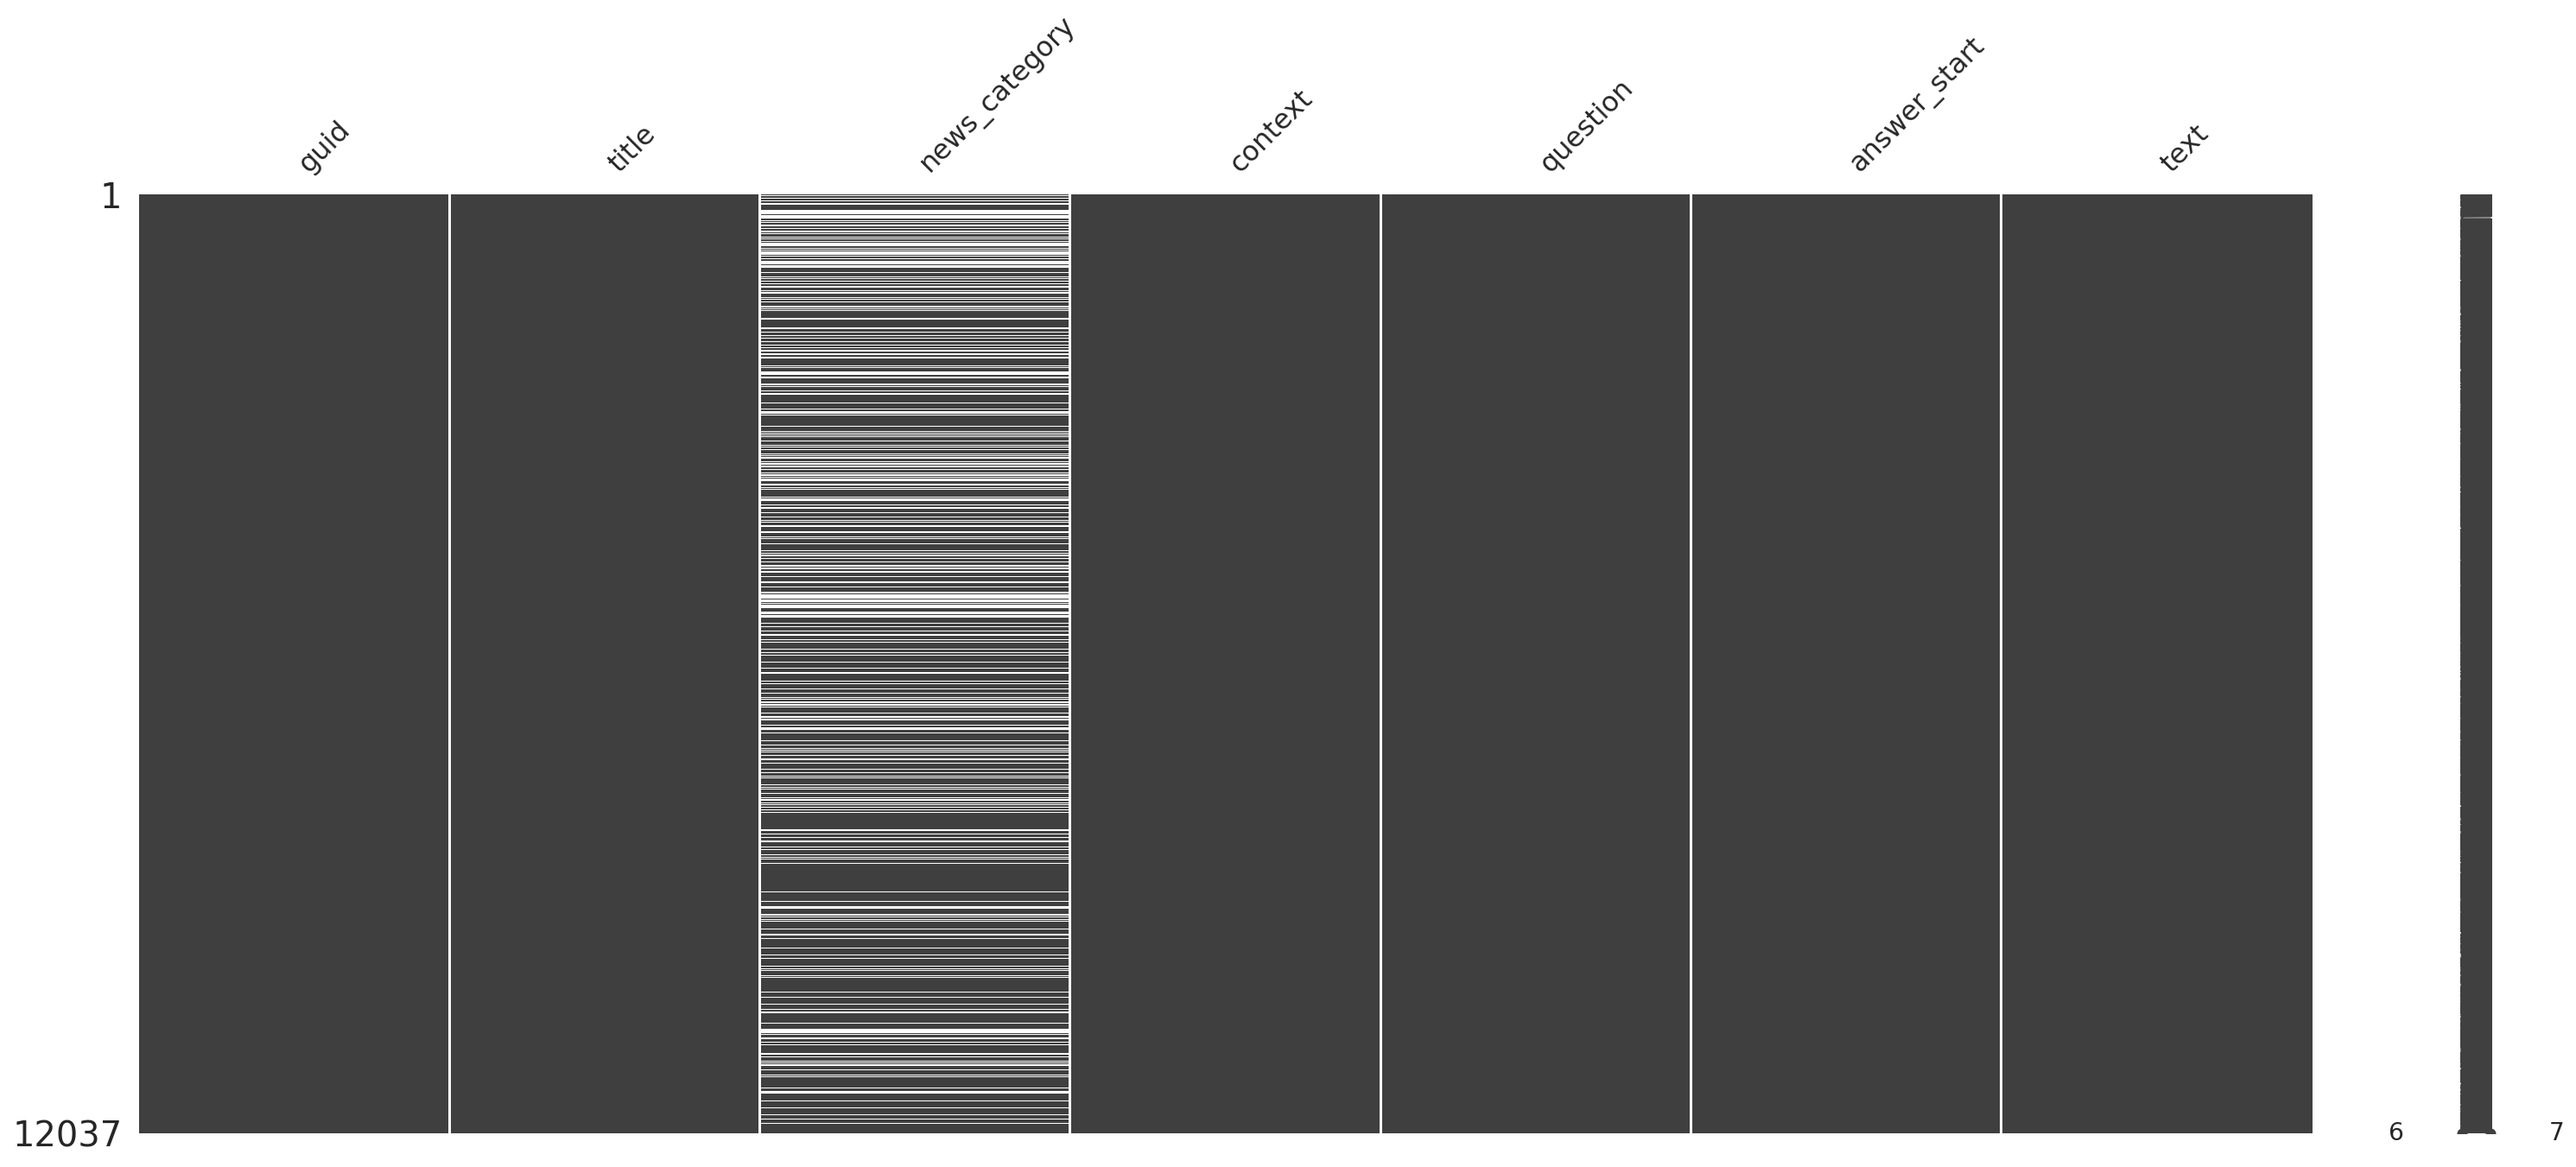

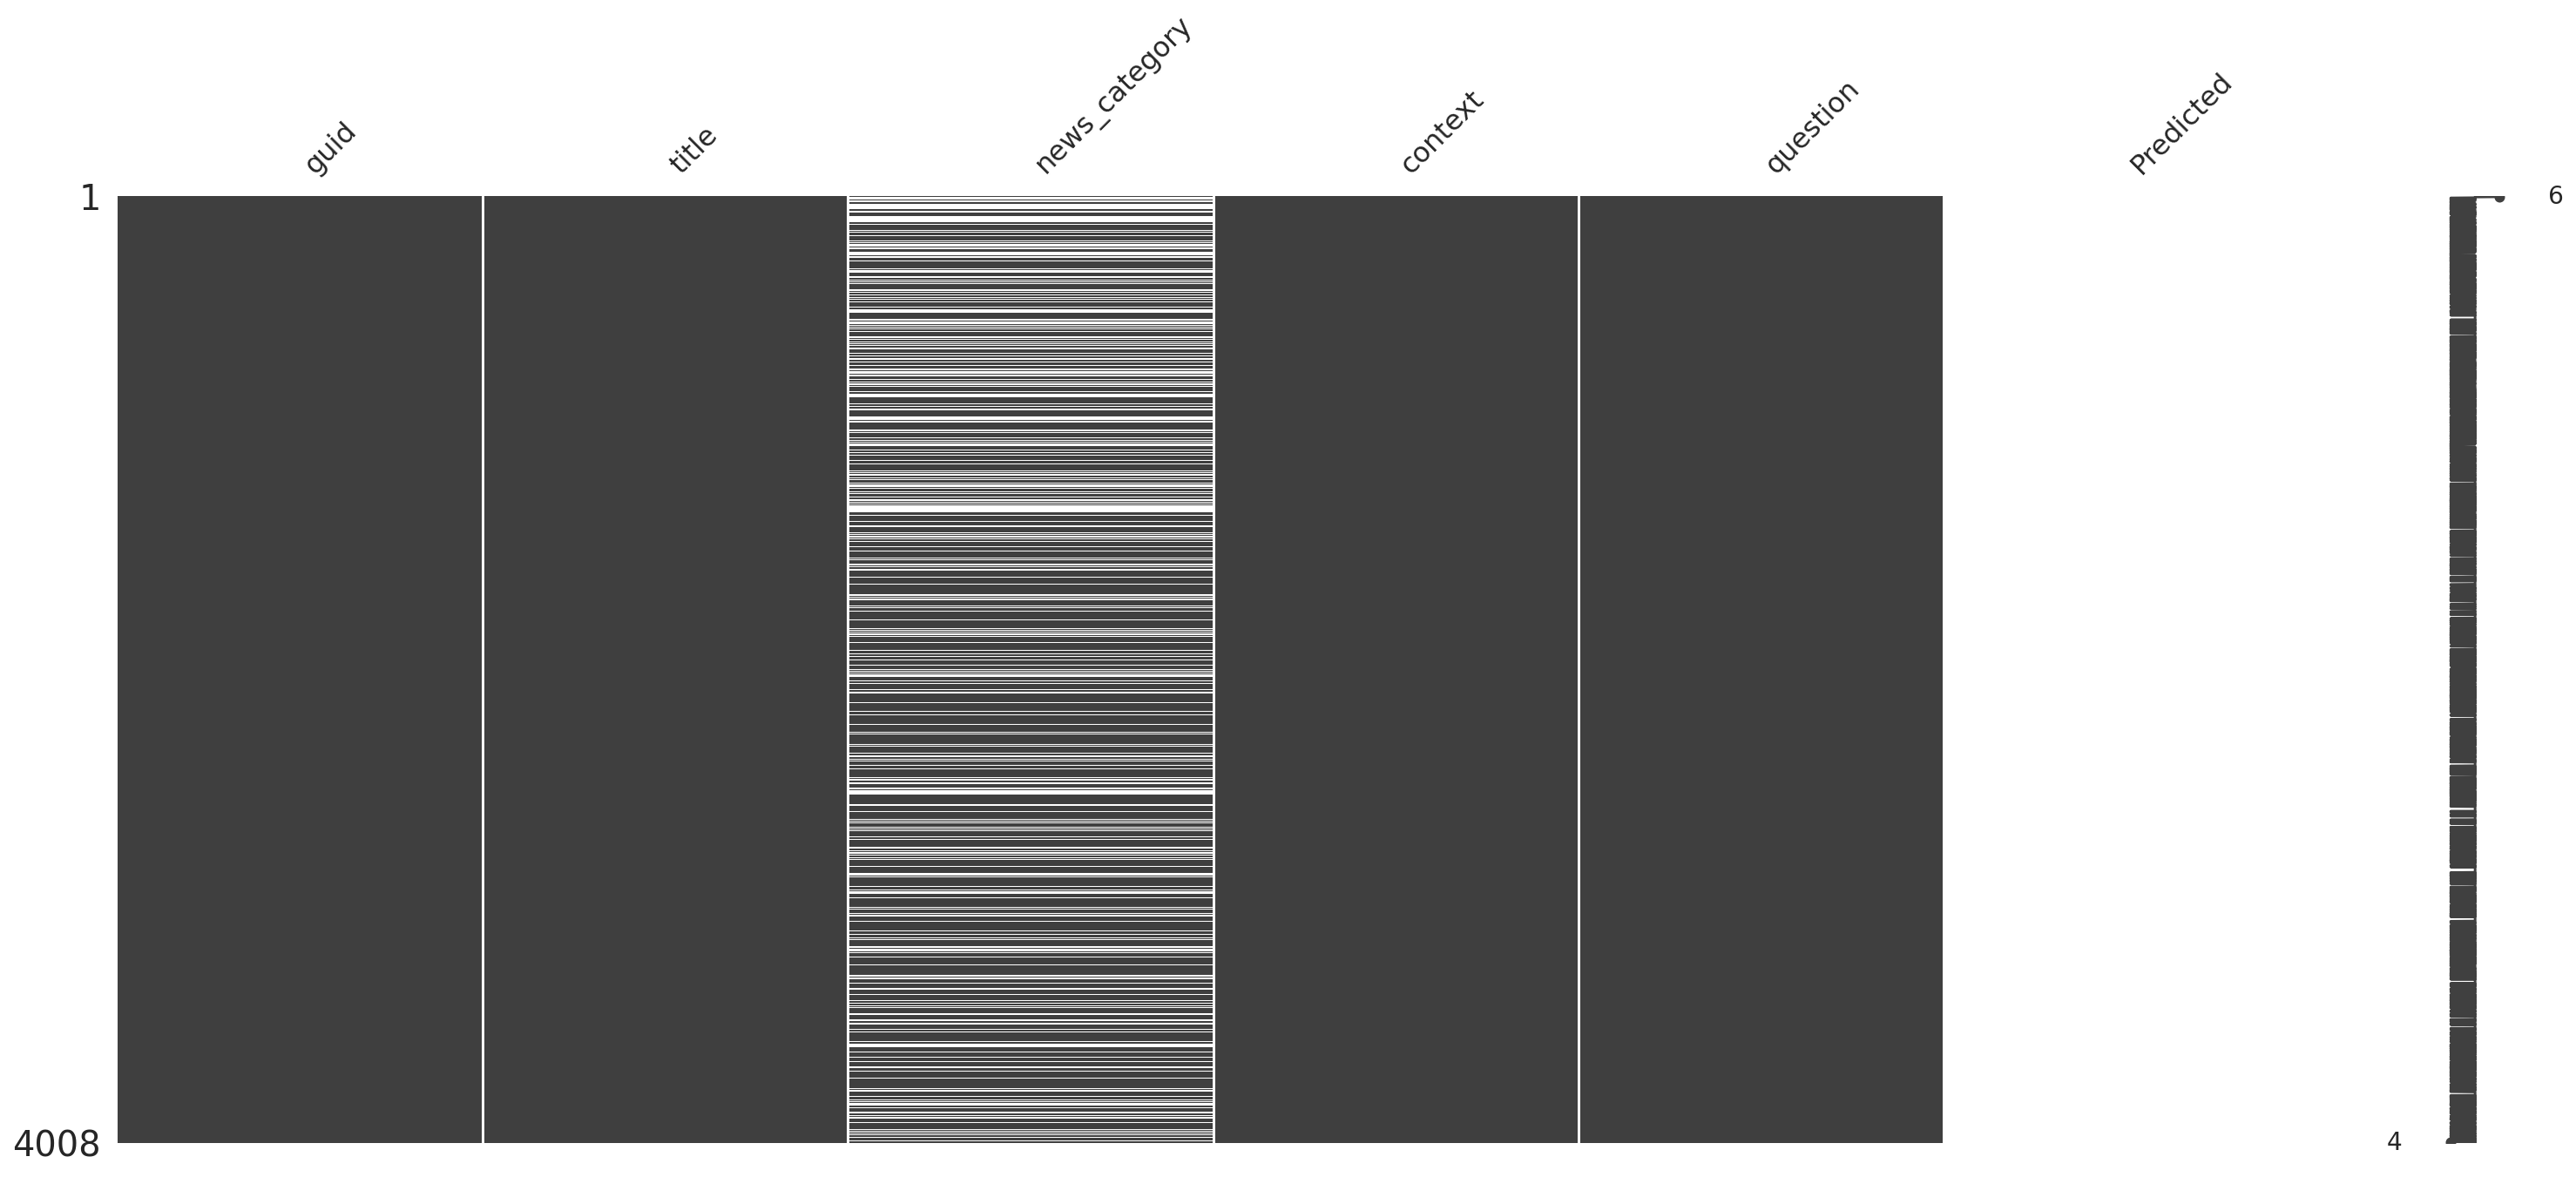

In [ ]:
import missingno as msno

msno.matrix(train)

msno.matrix(test)

In [ ]:
train.head()

,guid,title,context,question,answer_start,text
0,798db07f0b9046759deed9d4a35ce31e,제주도 장마 시작 … 중부는 이달 말부터,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,478,한 달가량
1,67c85e4f86ae43939b807684537c909c,"부산정보산업진흥원, 과기부 지역SW서비스사업화 지원사업 4개 과제 선정",부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?,1422,삼보테크놀로지
2,d2764543b0a84596942b34071541bed4,나루세 요시히사,시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?,107,와쿠이 히데아키
3,435aa49b68e8414d8c5e4f8102782b81,편의점 휩쓴 ‘맛집 라면’,유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?,408,‘교동반점 짬뽕’
4,4fa200ce1e3a4a279c43c1de40fb27b3,편의점 휩쓴 ‘맛집 라면’,유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,재작년 세븐일레븐 컵라면 중 제일 많이 팔린 제품은?,616,‘불닭볶음면’


In [ ]:
train.describe()

,guid,title,context,question,answer_start,text
count,255462,255462,255462,255462,255462,255462
unique,255462,48290,55898,253612,2201,190982
top,c1_217326-1,9433,"""미국의 시리아 공격이 임박했다는 관측이 나오는 가운데, 미국과 영국 정상이 전화통...",미국 대통령은 누구인가?,0,14일
freq,1,57,32,36,8861,522


In [ ]:
MODEL_NAME = 'digit82/kolang-t5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/926k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [ ]:
text_token_counts, question_token_counts = [], []

for _, row in train.iterrows():
    text_token_count = len(tokenizer.encode(row['context']))
    text_token_counts.append(text_token_count)

    question_token_count = len(tokenizer.encode(row['text']))
    question_token_counts.append(question_token_count)

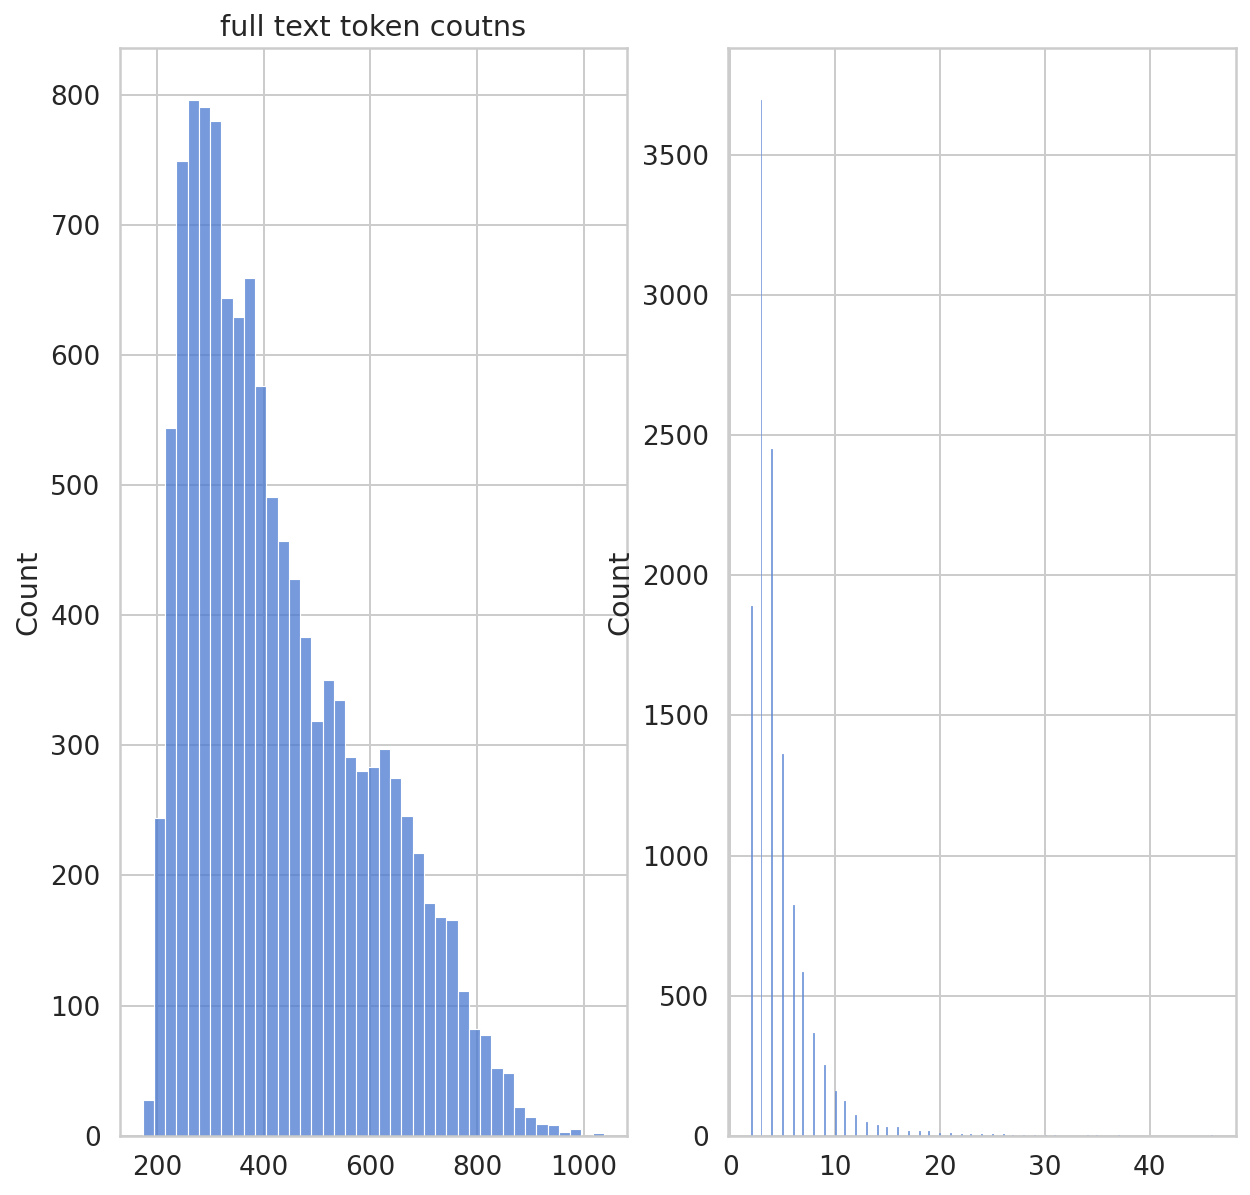

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token coutns')
sns.histplot(question_token_counts, ax=ax2)

# 3. Model

In [ ]:
train['context'][0]

'올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.'

In [ ]:
sample_encoding = tokenizer(train['context'][0])

In [ ]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(sample_encoding["input_ids"])
print(sample_encoding["attention_mask"])
print(len(sample_encoding['input_ids']), len(sample_encoding['attention_mask']))

[1139, 13469, 1108, 10770, 1714, 33542, 5189, 1009, 8657, 33508, 1162, 1022, 18225, 33521, 30398, 21986, 34166, 1516, 13498, 2760, 1054, 33796, 1108, 10770, 19544, 2851, 33508, 4614, 33542, 29874, 1487, 5189, 8352, 28328, 33510, 1074, 15842, 33534, 4612, 6208, 1272, 5189, 25885, 1224, 9359, 9355, 19067, 18196, 2237, 3003, 8698, 1710, 7909, 33510, 24505, 1514, 4622, 5007, 33508, 19718, 1108, 10454, 22256, 1016, 34654, 33584, 33542, 33614, 1322, 3022, 2217, 8325, 8657, 33508, 1108, 10454, 1029, 8075, 33687, 33516, 28178, 1014, 5429, 1018, 34432, 4643, 33980, 33516, 1051, 33678, 33966, 33733, 33526, 1014, 2809, 2038, 4069, 1308, 15842, 33534, 5496, 9473, 28115, 13627, 33508, 33537, 33606, 33534, 5282, 1546, 33542, 5189, 2082, 8352, 1063, 4016, 2237, 34038, 2156, 1059, 23400, 1522, 19679, 33526, 2622, 22962, 1095, 2382, 1369, 1115, 1829, 33508, 1574, 1309, 1059, 34654, 6113, 33542, 20742, 1265, 30398, 7697, 1516, 1108, 10770, 8325, 1866, 33715, 2851, 33508, 1486, 15842, 33534, 1947, 7224, 

In [ ]:
 preds = [
          tokenizer.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
          for input_id in sample_encoding['input_ids']
 ]
 preds= " ".join(preds)
 preds

'올 여름 장 마가 17 일 제주도 에서 시작됐다 . 서울 등 중부지방 은 예년보다 사나 흘 정도 늦은 이달 말 께 장 마가 시작될 전망이다 . 17 일 기상청에 따르면 제주도 남쪽 먼바다 에 있는 장마 전 선의 영향으로 이날 제주도 산간 및 내륙 지역에 호우 주의보가 내려 지면서 곳곳에 100 mm 에 육박하는 많은 비가 내렸다 . 제주의 장 마는 평년보다 2 ~ 3 일 , 지난해 보다는 하루 일찍 시작됐다 . 장 마는 고 온다 습 한 북태평양 기 단과 한 랭 습 윤 한 오 호 츠 크 해 기 단이 만나 형성 되는 장마 전 선에서 내리는 비를 뜻한다 . 장 마 전 선은 18 일 제주도 먼 남쪽 해 상으로 내려 갔 다가 20 일께 다시 북상 해 전남 남해안 까지 영향을 줄 것으로 보인다 . 이에 따라 20 ~ 21 일 남부지방 에도 예년보다 사흘 정도 장 마가 일찍 찾아 올 전망이다 . 그러나 장마 전 선을 밀어 올 리는 북태평양 고기 압 세력이 약해 서울 등 중부지방 은 평년보다 사나 흘 가량 늦은 이달 말부터 장 마가 시작될 것이라는 게 기상 청의 설명이다 . 장마 전 선은 이후 한 달 가량 한반도 중남 부를 오르내 리며 곳곳에 비를 뿌 릴 전망이다 . 최근 30 년간 평균치에 따르면 중부지방 의 장마 시작 일은 6 월 24 ~ 25 일 이었으며 장마 기간은 32 일 , 강수 일 수는 17. 2 일 이었다 . 기상 청은 올해 장마 기간 의 평균 강수 량이 350 ~ 400 mm 로 평 년과 비슷하거나 적을 것으로 내다봤다 . 브라질 월드컵 한국과 러시아의 경기가 열리는 18 일 오전 서울은 대체로 구름이 많이 끼 지만 비는 오지 않을 것으로 예상돼 거리 응원 에는 지장이 없을 전망이다 . </s>'

In [ ]:
encoding = tokenizer(train['question'][0], train['context'][0], max_length=512, padding='max_length', 
                     truncation='only_second', return_attention_mask=True, add_special_tokens=True, return_tensors='pt')

In [ ]:
tokenizer.decode(encoding['input_ids'].squeeze())


'북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?</s> 올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100mm에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400mm로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [ ]:
 answer_encoding = tokenizer(
     train['text'][0],
     max_length=32,
     padding='max_length',
     truncation=True,
     return_attention_mask=True,
     add_special_tokens=True,
     return_tensors="pt"
 )
 print(tokenizer.decode(answer_encoding['input_ids'].squeeze()))
 labels = answer_encoding["input_ids"]
 labels
 labels[labels == 0] = -100
 labels 

한 달가량</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


tensor([[1018, 1196, 5439,    3, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100]])


# Create Dataset

In [ ]:
class KorQuadDataset(Dataset):
  def __init__(
      self, data:pd.DataFrame, 
      tokenizer:T5Tokenizer,
      source_max_token_len: int = 512,
      target_max_token_len: int = 32
      ):
    self.data = data
    self.tokenizer = tokenizer
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    source_encoding = tokenizer(
        data_row['question'],
        data_row['context'],
        max_length=self.source_max_token_len,
        padding='max_length',
        truncation='only_second',
        return_attention_mask=True,
        return_tensors='pt'
    )

    target_encoding = tokenizer(
        data_row['text'],
        max_length=self.target_max_token_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )

    labels = target_encoding['input_ids']
    labels[labels==0] = -100
    return dict(
        question=data_row['question'],
        context=data_row['context'],
        answer_text=data_row['text'],
        input_ids=source_encoding['input_ids'].flatten(),
        attention_mask=source_encoding['attention_mask'].flatten(),
        labels=labels.flatten()
    )
  


In [ ]:
sample_dataset = KorQuadDataset(train, tokenizer)

In [ ]:
test_sample = next(iter(sample_dataset))

In [ ]:
for data in sample_dataset:
  print("Question: ", data['question'])
  print("Anser text: ", data['answer_text'])
  print("Input ids: ", data['input_ids'][:10])
  print("Label: ", data['labels'][:10])
  break

Question:  북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
Anser text:  한 달가량
Input ids:  tensor([28178,  1014,  5429,  1051, 33678, 33966, 33733, 33526,  1014,  2809])
Label:  tensor([1018, 1196, 5439,    3, -100, -100, -100, -100, -100, -100])



# Pytorch Lightning Module

In [ ]:
class KorQuadModule(pl.LightningDataModule):
  def __init__(
      self, 
      train_df: pd.DataFrame,
      test_df: pd.DataFrame,
      tokenizer: tokenizer,
      batch_size: int = 4,
      source_max_token_len: int = 512,
      target_max_token_len: int = 32
  ):
    super().__init__()
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len
  def setup(self):
    self.train_dataset = KorQuadDataset(
        self.train_df,
        self.tokenizer,
        self.source_max_token_len,
        self.target_max_token_len
    )
    self.test_dataset = KorQuadDataset(
        self.test_df,
        self.tokenizer,
        self.source_max_token_len,
        self.target_max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=4
    )
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        num_workers=4 

    )


In [ ]:
 BATCH_SIZE = 4
 N_EPOCHS = 20
 data_module = KorQuadModule(train, val_df, tokenizer, batch_size=BATCH_SIZE)

In [ ]:
data_module.setup() 


# Loading and Fine Tuning T5

In [ ]:
 model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)

In [ ]:
model.config

T5Config {
  "_name_or_path": "digit82/kolang-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 3,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 152,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "prefix": "translate English to German: "
    },
    "translation_en_to_fr": {
   

In [ ]:
class KorQuadModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.model(input_ids, attention_mask=attention_mask, labels=labels)
    return output.loss, output.logits

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss":loss, "prediections": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask=batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask=batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=0.0005) # 0.0001 -> 0.0005
    return optimizer

In [ ]:
model = KorQuadModel()

Downloading:   0%|          | 0.00/859M [00:00<?, ?B/s]

In [ ]:
logger = TensorBoardLogger("lightning_logs", name='Korquad_log')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_callback = ModelCheckpoint(
    filename="/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")


In [ ]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=20,
    #gpus=1,
    tpu_cores=8,
    progress_bar_refresh_rate=30)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
 trainer.fit(model, data_module)
 # trainer.test()

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 225 M 
-----------------------------------------------------
225 M     Trainable params
0         Non-trainable params
225 M     Total params
900.744   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 7945: val_loss reached 4.41103 (best 4.41103), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 15891: val_loss reached 4.27293 (best 4.27293), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 23837: val_loss reached 4.08588 (best 4.08588), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 31783: val_loss reached 4.04251 (best 4.04251), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 39729: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 47675: val_loss reached 3.97249 (best 3.97249), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 55621: val_loss reached 3.91648 (best 3.91648), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 63567: val_loss reached 3.87328 (best 3.87328), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 71513: val_loss reached 3.83899 (best 3.83899), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 79459: val_loss reached 3.81607 (best 3.81607), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 87405: val_loss reached 3.76105 (best 3.76105), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 95351: val_loss reached 3.69486 (best 3.69486), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 103297: val_loss reached 3.66025 (best 3.66025), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt" as top 1


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs
#!rm --rf lightning_logs
#/content/lightning_logs

In [ ]:
 trained_model = KorQuadModel.load_from_checkpoint("/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v8.ckpt")
 # trained_model.freeze()

Downloading:   0%|          | 0.00/859M [00:00<?, ?B/s]

* 추가 학습


In [ ]:
trainer.fit(trained_model, data_module)

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 225 M 
-----------------------------------------------------
225 M     Trainable params
0         Non-trainable params
225 M     Total params
900.744   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 7945: val_loss reached 2.29414 (best 2.29414), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v9.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 15891: val_loss reached 2.24295 (best 2.24295), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v9.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 23837: val_loss reached 2.21087 (best 2.21087), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v9.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 31783: val_loss reached 2.16989 (best 2.16989), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v9.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 39729: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 47675: val_loss was not in top 1


In [ ]:
 trained_model = KorQuadModel.load_from_checkpoint("/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/best-checkpoint-v9.ckpt")
 # trained_model.freeze()

Downloading:   0%|          | 0.00/859M [00:00<?, ?B/s]

In [ ]:
def generate_answer(question):
  source_encoding = tokenizer(question['question'], question['context'], max_length=1024, padding='max_length', truncation='only_second',
                            return_attention_mask=True, return_tensors='pt')
  
  generated_ids = trained_model.model.generate(input_ids=source_encoding['input_ids'], attention_mask=source_encoding['attention_mask'],
                                         num_beams=5, max_length=20, repetition_penalty=2.5, early_stopping=True, use_cache=True)
  
  preds = [tokenizer.decode(generated_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for generated_id in generated_ids]

  return "".join(preds)

In [ ]:
sample_question = val_df.iloc[20]
print(sample_question["question"])
print(sample_question["text"])  


10.2 채널 오디오 기술에서 100Hz 이하의 가청 주파수 관련 스피커는 몇 개인가?
2개


In [ ]:
generate_answer(sample_question) 

'10.2 채널'

In [ ]:
test

,guid,title,news_category,context,question
0,d14cb73158624cf094c546d856fd3c80,"BMW 코리아, 창립 25주년 기념 ‘BMW 코리아 25주년 에디션’ 한정 출시",자동차,BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에...,말라카이트에서 나온 색깔을 사용한 에디션은?
1,906631384e91493ebe1c7f34aea6f241,"佛 검찰 “독일 여객기, 부조종사가 의도적으로 추락”",국제,프랑스 남부 알프스에 떨어져 150명의 사망자를 낸 저먼윙스 여객기는 부조종사가 의...,사고 비행기의 목적지는?
2,35e61dcb479643448a2cb7d326ae50a6,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,2014년 일하고 싶은 50대 회사 중에서 5위로 선정된 기업은?
3,075e761b370040cb9041eecd39afc27c,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,포브스의 2014년 일하고 싶은 50대 회사 조사에서 5위를 한 기업은?
4,e67ed38f3dd944be94d5b4c53731f334,호세 카레라스,None,성악가로서 한창 전성기를 구가하던 1987년 호세 카레라스는 청천벽력같은 소식을 듣...,호세 카레라스가 재단의 도움을 받아 병을 치료한 병원의 소재지는?
...,...,...,...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,"企銀, 전 해외지점장 대출한도 축소",금융,일본 도쿄지점 130억원대 부당대출 혐의로 금융감독원의 검사를 받고 있는 기업은행이...,도쿄지점의 현재 개인 신용대출 한도는?
4004,cc7f826b66724ce9b39e3a974ca15661,그해 겨울은 따뜻했네,None,한국전쟁 당시 언니인 수지는 여동생 오목이를 고의로 방치했다. 수지는 신경쓰지 않고...,오목이 수지에게 청탁한 남편의 일자리 장소는?
4005,3282034aa41e4fab980851ffd4a868dd,‘안개’에 파묻힌 해운업계 … 공급 과잉에 컨船 운임 사상최저,산업섹션,세계 컨테이너선 운임지수가 사상 최저 수준으로 떨어지면서 해운업계에 비상이 걸렸다....,컨테이너선 평균 운임이 15%정도 낮아진 노선은?
4006,0a73550b36df4baf82ac2f98619d22e7,강남·서초 유치원·초교 8~10일 전면휴업,사회,"서울교육청이 8일부터 10일까지 강남구, 서초구 지역에 있는 유치원, 초등학교의 전...",강남지역에 사는 학생들은 며칠 동안 학교를 안가나?


# Predict

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/baseline.csv')

In [ ]:
submission.head()

,Id,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴
1,906631384e91493ebe1c7f34aea6f241,"의도적으로 여객기 하강버튼을 눌렀고, 여객기의 하강속도가 빨라졌다”며 “사고 직전 ..."
2,35e61dcb479643448a2cb7d326ae50a6,미국
3,075e761b370040cb9041eecd39afc27c,“톱 50 가운데 22개가 IT 기업
4,e67ed38f3dd944be94d5b4c53731f334,백혈병


In [ ]:
for i in tqdm(range(0, len(test))):
  test.loc[i, 'Predicted'] = generate_answer(test.iloc[i])


  0%|          | 0/4008 [00:00<?, ?it/s]

In [ ]:
test                                                        

,guid,title,news_category,context,question,Predicted
0,d14cb73158624cf094c546d856fd3c80,"BMW 코리아, 창립 25주년 기념 ‘BMW 코리아 25주년 에디션’ 한정 출시",자동차,BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에...,말라카이트에서 나온 색깔을 사용한 에디션은?,몰디브 블루 컬러
1,906631384e91493ebe1c7f34aea6f241,"佛 검찰 “독일 여객기, 부조종사가 의도적으로 추락”",국제,프랑스 남부 알프스에 떨어져 150명의 사망자를 낸 저먼윙스 여객기는 부조종사가 의...,사고 비행기의 목적지는?,“부조종사의 테러 연관성은 확인되지 않았다”
2,35e61dcb479643448a2cb7d326ae50a6,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,2014년 일하고 싶은 50대 회사 중에서 5위로 선정된 기업은?,베인
3,075e761b370040cb9041eecd39afc27c,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,포브스의 2014년 일하고 싶은 50대 회사 조사에서 5위를 한 기업은?,트위터
4,e67ed38f3dd944be94d5b4c53731f334,호세 카레라스,None,성악가로서 한창 전성기를 구가하던 1987년 호세 카레라스는 청천벽력같은 소식을 듣...,호세 카레라스가 재단의 도움을 받아 병을 치료한 병원의 소재지는?,도밍고
...,...,...,...,...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,"企銀, 전 해외지점장 대출한도 축소",금융,일본 도쿄지점 130억원대 부당대출 혐의로 금융감독원의 검사를 받고 있는 기업은행이...,도쿄지점의 현재 개인 신용대출 한도는?,14일
4004,cc7f826b66724ce9b39e3a974ca15661,그해 겨울은 따뜻했네,None,한국전쟁 당시 언니인 수지는 여동생 오목이를 고의로 방치했다. 수지는 신경쓰지 않고...,오목이 수지에게 청탁한 남편의 일자리 장소는?,중동
4005,3282034aa41e4fab980851ffd4a868dd,‘안개’에 파묻힌 해운업계 … 공급 과잉에 컨船 운임 사상최저,산업섹션,세계 컨테이너선 운임지수가 사상 최저 수준으로 떨어지면서 해운업계에 비상이 걸렸다....,컨테이너선 평균 운임이 15%정도 낮아진 노선은?,2.5달러
4006,0a73550b36df4baf82ac2f98619d22e7,강남·서초 유치원·초교 8~10일 전면휴업,사회,"서울교육청이 8일부터 10일까지 강남구, 서초구 지역에 있는 유치원, 초등학교의 전...",강남지역에 사는 학생들은 며칠 동안 학교를 안가나?,8일부터 10일까지


In [ ]:
submission['Predicted'] = test['Predicted']

In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/goormkoreanmrcproject/KorQuad-T5_v7.csv', index=False)


## levenshtein score 계산

In [ ]:
def levenshtein(s1, s2, debug=False):
    if len(s1) < len(s2):
        return levenshtein(s2, s1, debug)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))

        if debug:
            print(current_row[1:])

        previous_row = current_row

    return previous_row[-1]

In [ ]:
val_df

,guid,title,news_category,context,question,answer_start,text
0,71a97d4e2e6041c3b6f4822e262af3a5,"세부퍼시픽, 승객 편의 위해 유연한 여행 정책 연장 발표",산업,세부퍼시픽은 신종 코로나바이러스 감염증(코로나19)로 인한 항공 여행에 대한 불안감...,웹 사이트 아이디가 없어도 예약 변경을 하기 위해서 알고 있어야 하는 것은?,1241,예약 번호
1,b944559dad9b4ef7b67df94250f14e1b,‘위대한 개츠비’ 전자책보다 더 싸져,문화/TV,리어나도 디캐프리오 주연의 할리우드 영화 ‘위대한 개츠비’가 개봉하면서 F 스콧 피...,위대한 개츠비' 책을 구매하면 전자책을 제공하는 출판사는?,277,민음사
2,e91afb4862f9416091c263b767d51da5,"他지역 기업 차별 ‘지자체 조례’ 손본다...공정위, 5년만에 조사 착수 … 대형마...",경제,공정거래위원회가 지방자치단체의 조례와 규칙을 전수조사해 공정 경쟁을 저해하는 조항들...,서울 강남구에서 주차장 허가를 내려면 누구의 허가를 받아야 하는가?,971,해당 지자체장
3,2b8fac9d5dba4d0f81c386fb238ccfa9,"오텍그룹, KLPGA투어 ‘2020 오텍캐리어 챔피언십’ 개최",생활,오텍그룹은 자사가 주최하는 한국여자프로골프(KLPGA) 투어 ‘2020 오텍캐리어 ...,굿바이 러스 존에 골프공이 올라갔을 때 기부 받는 기관은?,1063,사랑의 열매
4,26b7e93606ed459da07b5801c45a276e,선글라스 ...뻔하다고?,기획,본격적인 휴가철을 앞두고 선글라스 매장이 북적이고 있다. 선글라스는 바캉스 패션을 ...,딥 프리즈 같이 최근 사람들에게 호평받는 안경의 특징은?,1585,투명 안경테
...,...,...,...,...,...,...,...
1199,b2a949e70a7142a39da5dba1b75e2f42,대한불교조계종,None,대한불교조계종(大韓佛敎曹溪宗)은 대한민국 불교 최대 종단(종파)이다. 조계종은 중국...,법맥과 전등을 중시하면 스승없이 깨달음을 얻을 수 없다고 주장한 사람은?,265,성철(이영주)
1200,115521b9ae074e5484c4417092eb85d7,‘시장선도’ LG전자의 파격행보...“대박 아이디어 매출 4% 드립니다”,기업&CEO,LG전자는 창의적이고 실용적인 일반 소비자들의 아이디어를 상품화한 뒤 매출의 4%를...,아이디어LG' 홈페이지'에서 아이디어를 내려는 소비자가 해야하는 것은?,429,아이디어 제안서를 등록하면 된다
1201,bbf3fd2d6a4d48198ce11d9fcc03fbe7,"LG, 카톡버튼 달린 폴더 스마트폰",IT모바일,LG전자가 모바일 메신저인 카카오톡의 전용 구동 버튼을 적용한 폴더형 스마트폰(사진...,시장에 와인폰이 처음 나온 해는 언제인가?,759,2007년
1202,2308cc16253f449da9f86018253ac4fd,삼성·LG ‘눈동자 인식’ 분쟁 조짐,IT모바일,삼성전자가 지난 14일 미국 뉴욕에서 공개한 스마트폰 갤럭시S4에 채택된 ‘눈동자 ...,스마트 스크린 기술을 최초로 적용한 삼성전자의 스마트폰 이름은?,336,‘갤럭시S3’


In [ ]:
for i in tqdm(range(0, len(val_df))):
  val_df.loc[i, 'Predicted'] = generate_answer(val_df.iloc[i])

  0%|          | 0/1204 [00:00<?, ?it/s]

In [ ]:
val_df

,guid,title,news_category,context,question,answer_start,text,Predicted,levenshtein
0,71a97d4e2e6041c3b6f4822e262af3a5,"세부퍼시픽, 승객 편의 위해 유연한 여행 정책 연장 발표",산업,세부퍼시픽은 신종 코로나바이러스 감염증(코로나19)로 인한 항공 여행에 대한 불안감...,웹 사이트 아이디가 없어도 예약 변경을 하기 위해서 알고 있어야 하는 것은?,1241,예약 번호,예약 번호,0.0
1,b944559dad9b4ef7b67df94250f14e1b,‘위대한 개츠비’ 전자책보다 더 싸져,문화/TV,리어나도 디캐프리오 주연의 할리우드 영화 ‘위대한 개츠비’가 개봉하면서 F 스콧 피...,위대한 개츠비' 책을 구매하면 전자책을 제공하는 출판사는?,277,민음사,한국출판인회의,7.0
2,e91afb4862f9416091c263b767d51da5,"他지역 기업 차별 ‘지자체 조례’ 손본다...공정위, 5년만에 조사 착수 … 대형마...",경제,공정거래위원회가 지방자치단체의 조례와 규칙을 전수조사해 공정 경쟁을 저해하는 조항들...,서울 강남구에서 주차장 허가를 내려면 누구의 허가를 받아야 하는가?,971,해당 지자체장,지자체장,3.0
3,2b8fac9d5dba4d0f81c386fb238ccfa9,"오텍그룹, KLPGA투어 ‘2020 오텍캐리어 챔피언십’ 개최",생활,오텍그룹은 자사가 주최하는 한국여자프로골프(KLPGA) 투어 ‘2020 오텍캐리어 ...,굿바이 러스 존에 골프공이 올라갔을 때 기부 받는 기관은?,1063,사랑의 열매,건설공제조합,6.0
4,26b7e93606ed459da07b5801c45a276e,선글라스 ...뻔하다고?,기획,본격적인 휴가철을 앞두고 선글라스 매장이 북적이고 있다. 선글라스는 바캉스 패션을 ...,딥 프리즈 같이 최근 사람들에게 호평받는 안경의 특징은?,1585,투명 안경테,코렌,7.0
...,...,...,...,...,...,...,...,...,...
1199,b2a949e70a7142a39da5dba1b75e2f42,대한불교조계종,None,대한불교조계종(大韓佛敎曹溪宗)은 대한민국 불교 최대 종단(종파)이다. 조계종은 중국...,법맥과 전등을 중시하면 스승없이 깨달음을 얻을 수 없다고 주장한 사람은?,265,성철(이영주),석가모니,7.0
1200,115521b9ae074e5484c4417092eb85d7,‘시장선도’ LG전자의 파격행보...“대박 아이디어 매출 4% 드립니다”,기업&CEO,LG전자는 창의적이고 실용적인 일반 소비자들의 아이디어를 상품화한 뒤 매출의 4%를...,아이디어LG' 홈페이지'에서 아이디어를 내려는 소비자가 해야하는 것은?,429,아이디어 제안서를 등록하면 된다,‘아이디어LG’ 홈페이지 접속,12.0
1201,bbf3fd2d6a4d48198ce11d9fcc03fbe7,"LG, 카톡버튼 달린 폴더 스마트폰",IT모바일,LG전자가 모바일 메신저인 카카오톡의 전용 구동 버튼을 적용한 폴더형 스마트폰(사진...,시장에 와인폰이 처음 나온 해는 언제인가?,759,2007년,2007년,0.0
1202,2308cc16253f449da9f86018253ac4fd,삼성·LG ‘눈동자 인식’ 분쟁 조짐,IT모바일,삼성전자가 지난 14일 미국 뉴욕에서 공개한 스마트폰 갤럭시S4에 채택된 ‘눈동자 ...,스마트 스크린 기술을 최초로 적용한 삼성전자의 스마트폰 이름은?,336,‘갤럭시S3’,갤럭시S4,3.0


In [ ]:
for i in range(0, len(val_df)):
  val_df.loc[i, 'levenshtein'] = levenshtein(val_df.loc[i, 'text'], val_df.loc[i, 'Predicted'])



In [ ]:
val_df['levenshtein'].mean()

3.490863787375415


### score 기록

* batch_size : 4, learnig_rate : 0.0001, num_beam : 1, encoding max_leghth : 1024, max_lenght : 32 ->  3.5913621262458473

* batch_size : 4, learnig_rate : 0.0001, num_beam : 5,encoding max_leghth : 1024, max_lenght : 32 ->  3.558139534883721

* batch_size : 4, learnig_rate : 0.0001, num_beam : 5,encoding max_leghth : 1024, max_lenght : 20 ->  3.548172757475083

* batch_size : 4, learnig_rate : 0.0001, num_beam : 5,encoding max_leghth : 1024 ,max_lenght : 20 ->  3.490863787375415

